# Imports

In [2]:
import pandas as pd 
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import punkt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
import string
from nltk.probability import FreqDist
import seaborn as sns
pd.options.display.max_rows = 999
pd.options.display.max_columns = 30
import lexnlp as lnlp
import src
import importlib
import unidecode as unidecode
importlib.reload(src)
%matplotlib inline


# Data Formating

## Importing SCDB file

In [3]:
df = pd.read_csv('../data/SCDB_2020_01_caseCentered_Citation.csv',encoding='cp1252' ) #importing data
df.head() #checking the DataFrame

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,term,naturalCourt,chief,docket,caseName,...,voteUnclear,issue,issueArea,decisionDirection,decisionDirectionDissent,authorityDecision1,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes
0,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,1946,1301,Vinson,24,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,...,0.0,80180.0,8.0,2.0,0.0,4.0,NaN,6.0,600.0,35 U.S.C. § 33,78.0,78.0,1,8,1
1,1946-002,1946-002-01,1946-002-01-01,1946-002-01-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,1946,1301,Vinson,12,CLEVELAND v. UNITED STATES,...,0.0,10500.0,1.0,1.0,0.0,4.0,NaN,6.0,600.0,18 U.S.C. § 398,81.0,87.0,1,6,3
2,1946-003,1946-003-01,1946-003-01-01,1946-003-01-01-01,11/18/1946,1,329 U.S. 29,67 S. Ct. 1,91 L. Ed. 22,1946 U.S. LEXIS 3037,1946,1301,Vinson,21,CHAMPLIN REFINING CO. v. UNITED STATES ET AL.,...,0.0,80250.0,8.0,2.0,0.0,1.0,NaN,2.0,207.0,NaN,84.0,78.0,1,5,4
3,1946-004,1946-004-01,1946-004-01-01,1946-004-01-01-01,11/25/1946,7,329 U.S. 40,67 S. Ct. 167,91 L. Ed. 29,1946 U.S. LEXIS 1696,1946,1301,Vinson,26,UNITED STATES v. ALCEA BAND OF TILLAMOOKS ET AL.,...,0.0,20150.0,2.0,2.0,0.0,4.0,NaN,6.0,600.0,49 Stat. 801,87.0,87.0,1,5,3
4,1946-005,1946-005-01,1946-005-01-01,1946-005-01-01-01,11/25/1946,1,329 U.S. 64,67 S. Ct. 154,91 L. Ed. 44,1946 U.S. LEXIS 2997,1946,1301,Vinson,50,"UNITED STATES v. HOWARD P. FOLEY CO., INC.",...,0.0,80060.0,8.0,2.0,0.0,7.0,NaN,NaN,NaN,NaN,78.0,87.0,1,6,3


## Filtering

In [4]:

df = df[df.partyWinning != 2]

## Extracting Important Features Based on my EDA

Since this data is almost all categorical data there are many Nans, they also decided to use floats for some reason. I'm going to extract my features then drop nans to preserve more rows.

In [161]:
#going down to just the factors I want to use based on EDA and intuition
#ie not including variable only known after the opinion is released etc...
df = df[['lcDispositionDirection', 'issue', 'naturalCourt', 'jurisdiction', 'caseSource', 'petitioner','partyWinning']]


## Cleaning

In [162]:
#dropping nans
df.dropna(inplace= True)

In [163]:
#checking for floats
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8759 entries, 0 to 9029
Data columns (total 7 columns):
lcDispositionDirection    8759 non-null float64
issue                     8759 non-null float64
naturalCourt              8759 non-null int64
jurisdiction              8759 non-null float64
caseSource                8759 non-null float64
petitioner                8759 non-null int64
partyWinning              8759 non-null float64
dtypes: float64(5), int64(2)
memory usage: 547.4 KB


In [164]:
for column in df.columns:
    df[column] = df[column].apply(lambda x: int(x))

In [165]:
#making sure it worked 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8759 entries, 0 to 9029
Data columns (total 7 columns):
lcDispositionDirection    8759 non-null int64
issue                     8759 non-null int64
naturalCourt              8759 non-null int64
jurisdiction              8759 non-null int64
caseSource                8759 non-null int64
petitioner                8759 non-null int64
partyWinning              8759 non-null int64
dtypes: int64(7)
memory usage: 547.4 KB


# Feature Creation

## Dummy Variables

In [166]:
#I wanted to run a logistic regression as a baseline, but some of the features have a ton of different categories (>600)
#to the point where creating dummy variables is impractical 
lgrdf = df[['lcDispositionDirection', 'issue', 'naturalCourt', 'jurisdiction', 'partyWinning']]

In [167]:
lgrdf = pd.get_dummies(lgrdf, columns = ['issue'], drop_first = True)
lgrdf = pd.get_dummies(lgrdf, columns = ['naturalCourt'], drop_first = True)
lgrdf = pd.get_dummies(lgrdf, columns = ['jurisdiction'], drop_first = True)
lgrdf = pd.get_dummies(lgrdf, columns = ['lcDispositionDirection'], drop_first = True)

In [168]:
#assigning my target to y and the predictive variables to y 
X = lgrdf.drop(['partyWinning'], axis = 1)
Y = lgrdf['partyWinning']

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=34)

# Logistic Regression Baseline

For my baseline model, I will use a logistic regression with a simple penalty and a balanced class weight. I am not expecting too much, but it is an easy, interpretable model.

In [170]:
#instancing a logistic regression model 
lgr = LogisticRegression(penalty = 'l2', class_weight= 'balanced')

In [171]:
#fitting 
lgr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [172]:
baseline_preds = lgr.predict(X_test)
baseline_preds_t = lgr.predict(X_train)

In [173]:
lgr_test_accuracy = accuracy_score(baseline_preds, y_test)
lgr_test_f1 = f1_score(baseline_preds, y_test)

### Evaulating the Test Predictions

In [58]:
print('Logistic Regression')
print("Testing Accuracy: {:.4}".format(lgr_test_accuracy))
print()
print("F1 Score: {:.4}".format(lgr_test_f1))

Logistic Regression
Testing Accuracy: 0.5793

F1 Score: 0.6489


In [59]:
confusion = confusion_matrix(y_test, baseline_preds)#generating a confusion matrix
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
#printing it in the format which I find most readable, rather than the graphic version
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 681
True Negatives: 334
 False Positives: 288
 False Negatives: 449



### Evaulating the Training predictions

In [60]:
lgr_train_accuracy = accuracy_score(baseline_preds_t, y_train)
lgr_train_f1 = f1_score(baseline_preds_t, y_train)

In [61]:
print('Logistic Regression')
print("Training Accuracy: {:.4}".format(lgr_train_accuracy))
print()
print("F1 Score: {:.4}".format(lgr_train_f1))


Logistic Regression
Training Accuracy: 0.6358

F1 Score: 0.6971


In [62]:
confusion = confusion_matrix(y_train, baseline_preds_t)#generating a confusion matrix
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
#printing it in the format which I find most readable, rather than the graphic version
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 2936
True Negatives: 1519
 False Positives: 954
 False Negatives: 1598



## Analysis

The baseline model does not have great accuracy, but this is not that surprising for a base line logistic regression, its pretty similar to just predicting the petitioner will win. It's also slightly overfit, this could be do to the large number of dummy categories but I am not sure.

## Assesing the Features

In [63]:
feature_importance = lgr.coef_[0]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# I got these in a pretty convolouted way, using np.argsort(feature_importance)[0:10] and np.argsort(feature_importance)[-10:]
#then just copy and pasting the numbers into a list 
sorted_idx = np.array([189, 153,  84,  12, 210,  82, 213, 162, 155,  62, 193, 272,  63,  25, 198, 138,  86,  87, 148, 125])



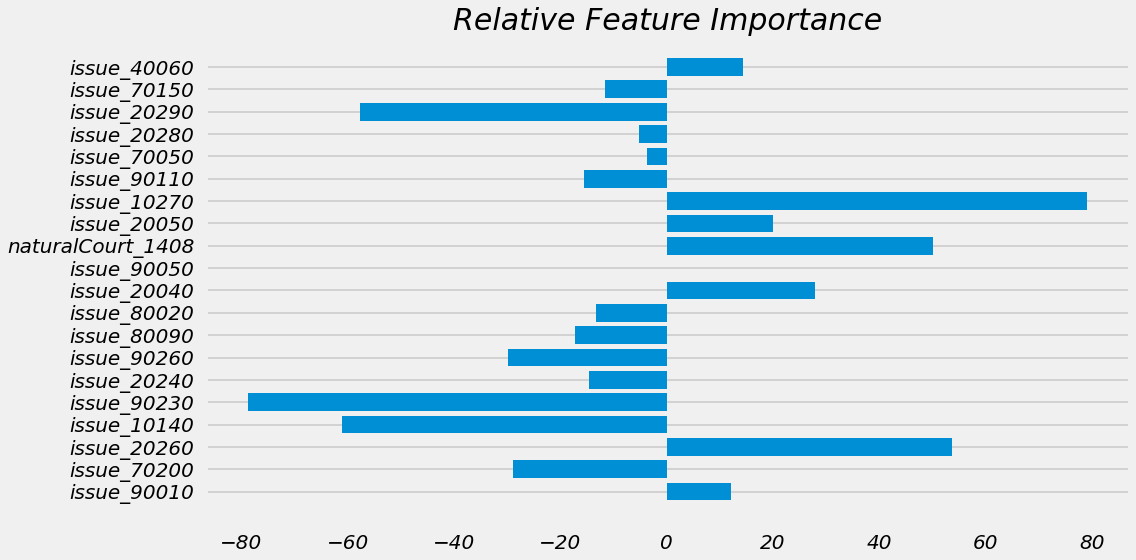

In [64]:
pos = np.arange(sorted_idx.shape[0]) + .5


plt.style.use(['fivethirtyeight']) #making my graphs purdy
plt.style.use(['seaborn-poster'])


featfig = plt.figure(figsize = (16,8))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_title("Relative Feature Importance", size = 30, style = 'oblique')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=20, style = 'italic')

plt.xticks(style = 'italic', size = 20)
plt.grid(axis = 'x')
featfig.tight_layout()

In [65]:
# I need to check what these are in the codebook
titles = ["No Merits: Writ Improvidently Granted","Employee Retirement Income Security Act","Immigration: Access to Public Education","Cruel and Unusual Punishment","Judicial Administration: Review of Non-Final Order","Immigration and Naturalization", "Judicial Adminstration","Patents and Copyrights","State or Local Government Regulation","Affirmative Action","No Merits: Remand to Determine Basis of State or Federal Court Decision","Roberts 3: 2009-2010","Sit in Demonstrations","Confrontation (Right to Confront Accuser, Call and Cross-Examine Witnesses" ,"Standing to Sue: Personal Injury","Labor Management Dispute: Right to Organize","Indigents: Appointment of Counsel","Indigents: Inadequate Representation by Counsel", 
"Suffiency of Evidence", "Commercial speech"] 


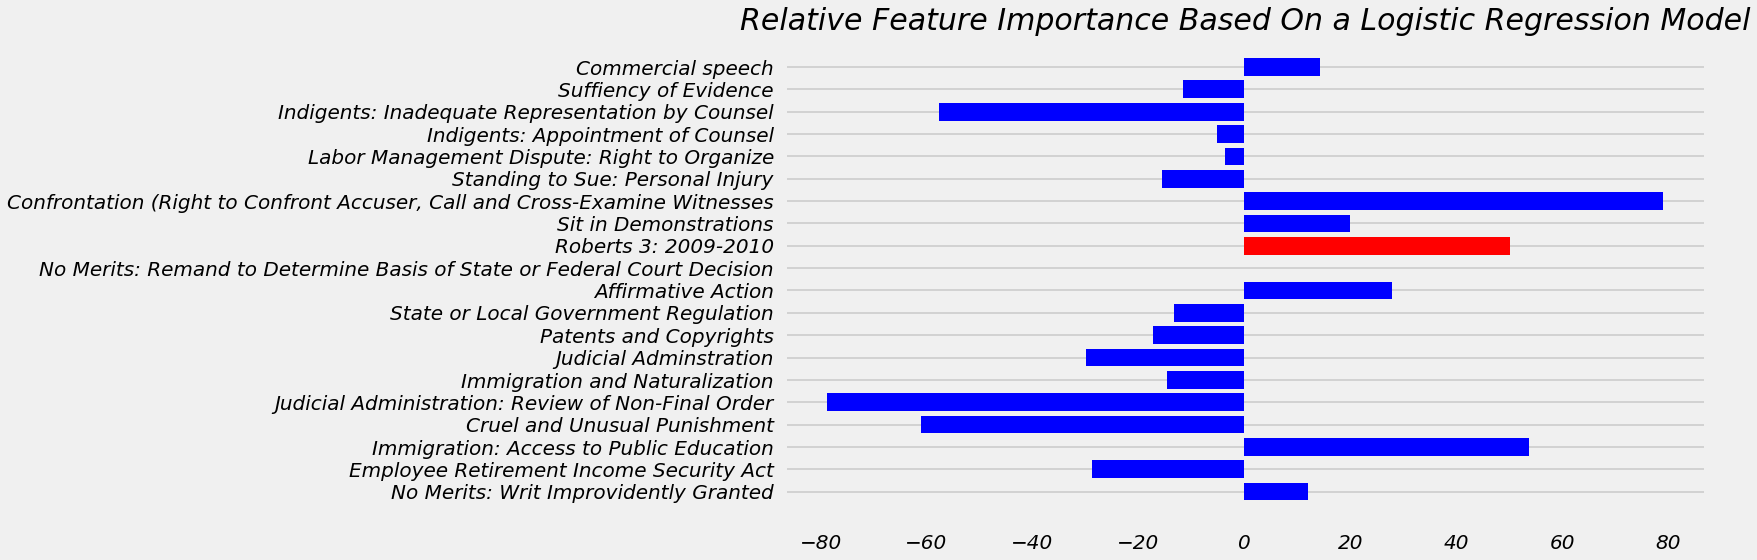

In [66]:
plt.style.use(['fivethirtyeight']) #making my graphs purdy
plt.style.use(['seaborn-poster'])

colorsls = []
for x in range(0,19):
    if x == 11:
        colorsls.append('red')
    else:
        colorsls.append('blue')

featfig = plt.figure(figsize = (24,8))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color = colorsls)
featax.set_title("Relative Feature Importance Based On a Logistic Regression Model", size = 30, style = 'oblique')
featax.set_yticks(pos)
featax.set_yticklabels(titles, fontsize=20, style = 'italic')
plt.xticks(style = 'italic', size = 20)
plt.grid(axis = 'x')
featfig.tight_layout()
plt.savefig('../data/most important features.png', bbox_inches = 'tight')

# RFC

A Random Forest Classifier is a good for categorization models and will naturally address the mild class imbalance.

In [67]:
#assigning my target to y and the predictive variables to y 
X = df.drop(['partyWinning'], axis = 1)
Y = df['partyWinning']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=34)

In [68]:
#instantiating the model
rfc = RandomForestClassifier(n_estimators=100, random_state=0, class_weight= 'balanced')

In [69]:
#fitting the model
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=0)

In [70]:
# making predictions
rfc_preds = rfc.predict(X_test)
rfc_preds_t = rfc.predict(X_train)

### Evaulating the Test Predictions

In [71]:
rfc_test_accuracy = accuracy_score(rfc_preds, y_test)
rfc_test_f1 = f1_score(rfc_preds, y_test)

In [72]:
print('Untuned Random Forest Classifier')
print("Testing Accuracy: {:.4}".format(rfc_test_accuracy))
print()
print("F1 Score: {:.4}".format(rfc_test_f1))

Untuned Random Forest Classifier
Testing Accuracy: 0.6484

F1 Score: 0.7486


In [73]:
confusion = confusion_matrix(y_test, rfc_preds)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 917
True Negatives: 219
 False Positives: 403
 False Negatives: 213



### Evaualting the Training Predictions

In [76]:
rfc_train_accuracy = accuracy_score(rfc_preds_t, y_train)
rfc_train_f1 = f1_score(rfc_preds_t, y_train)

In [77]:
print('Untuned Random Forest Classifier')
print("Training Accuracy: {:.4}".format(rfc_train_accuracy))
print()
print("F1 Score: {:.4}".format(rfc_train_f1))

Untuned Random Forest Classifier
Training Accuracy: 0.9803

F1 Score: 0.9847


In [78]:
confusion = confusion_matrix(y_train, rfc_preds_t)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 4452
True Negatives: 2417
 False Positives: 56
 False Negatives: 82



## Analysis

While more accutate then the logistic regression, this model is extremely overfit to the training data. Lets do a cross validated gridsearch to see if we can reduce the variance.

## Tuning hyper parameters

In [79]:
from sklearn.model_selection import GridSearchCV#importing the gridsearch module

In [80]:
param_grid = { 
    'n_estimators': [100, 150, 200, 250],
    'criterion': ['gini'],
    'max_depth': range(9,15),
    'max_features': ['auto']
}#the hyper parameters I will test

In [81]:
#instanting the search
grid_tree = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

In [82]:
#fitting
grid_tree.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.0min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': range(9, 15),
                         'max_features': ['auto'],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='accuracy', verbose=1)

In [83]:
#making predictions
grfc_preds = grid_tree.predict(X_test)
grfc_preds_t = grid_tree.predict(X_train)

### Evaulating the Testing Prediction

In [84]:
grfc_test_accuracy = accuracy_score(grfc_preds, y_test)
grfc_test_f1 = f1_score(grfc_preds, y_test)

In [85]:
print('Untuned Random Forest Classifier')
print("Testing Accuracy: {:.4}".format(grfc_test_accuracy))
print()
print("F1 Score: {:.4}".format(grfc_test_f1))

Untuned Random Forest Classifier
Testing Accuracy: 0.6724

F1 Score: 0.791


In [86]:
confusion = confusion_matrix(y_test, grfc_preds)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 1086
True Negatives: 92
 False Positives: 530
 False Negatives: 44



### Evaulating the Training Predictions

In [87]:
grfc_train_accuracy = accuracy_score(grfc_preds_t, y_train)
grfc_train_f1 = f1_score(grfc_preds_t, y_train)

In [88]:
print('Untuned Random Forest Classifier')
print("Testing Accuracy: {:.4}".format(grfc_train_accuracy))
print()
print("F1 Score: {:.4}".format(grfc_test_f1))

Untuned Random Forest Classifier
Testing Accuracy: 0.7306

F1 Score: 0.791


In [89]:
confusion = confusion_matrix(y_train, grfc_preds_t)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 4462
True Negatives: 657
 False Positives: 1816
 False Negatives: 72



## Analysis

This model is slightly more accurate and has a higher f1 score, but worringly, is also fairly overfit to the trainin data. Lets check the best hyper parameters and see if they are at the extremes of our ranges.

In [90]:
grid_tree.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 250}

Max depth is at the bottom of our range, lets run it again with lower possibiliies 

## Further Tuning

In [110]:
param_grid = { 
    'n_estimators': [100, 150, 200, 250],
    'criterion': ['gini'],
    'max_depth': range(1,10),
    'max_features': ['auto']
}#the hyper parameters I will test

In [102]:
#instanting the search
grid_tree = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

In [103]:
grid_tree.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.7min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': range(1, 10),
                         'max_features': ['auto'],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='accuracy', verbose=1)

In [109]:
grid_tree.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 200}

Looks like a max depth of nine was already the sweet spot, so this overfit model is the best we can do with only tuning our hyperparameters

# Adding Sentiment Analysis

In a final desperate attempt to glean something from my NLP work, I'm going to add sentiment analysis scores for the justice responses to the above model and see if it improves my accuracy. 

## Importing CSV

In [5]:
dfs = pd.read_csv("../data/justice_sentiment.csv")

In [6]:
df = pd.read_csv('../data/SCDB_2020_01_caseCentered_Citation.csv',encoding='cp1252' )

In [7]:
df.head()

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,term,naturalCourt,chief,docket,caseName,...,voteUnclear,issue,issueArea,decisionDirection,decisionDirectionDissent,authorityDecision1,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes
0,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,1946,1301,Vinson,24,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,...,0.0,80180.0,8.0,2.0,0.0,4.0,NaN,6.0,600.0,35 U.S.C. § 33,78.0,78.0,1,8,1
1,1946-002,1946-002-01,1946-002-01-01,1946-002-01-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,1946,1301,Vinson,12,CLEVELAND v. UNITED STATES,...,0.0,10500.0,1.0,1.0,0.0,4.0,NaN,6.0,600.0,18 U.S.C. § 398,81.0,87.0,1,6,3
2,1946-003,1946-003-01,1946-003-01-01,1946-003-01-01-01,11/18/1946,1,329 U.S. 29,67 S. Ct. 1,91 L. Ed. 22,1946 U.S. LEXIS 3037,1946,1301,Vinson,21,CHAMPLIN REFINING CO. v. UNITED STATES ET AL.,...,0.0,80250.0,8.0,2.0,0.0,1.0,NaN,2.0,207.0,NaN,84.0,78.0,1,5,4
3,1946-004,1946-004-01,1946-004-01-01,1946-004-01-01-01,11/25/1946,7,329 U.S. 40,67 S. Ct. 167,91 L. Ed. 29,1946 U.S. LEXIS 1696,1946,1301,Vinson,26,UNITED STATES v. ALCEA BAND OF TILLAMOOKS ET AL.,...,0.0,20150.0,2.0,2.0,0.0,4.0,NaN,6.0,600.0,49 Stat. 801,87.0,87.0,1,5,3
4,1946-005,1946-005-01,1946-005-01-01,1946-005-01-01-01,11/25/1946,1,329 U.S. 64,67 S. Ct. 154,91 L. Ed. 44,1946 U.S. LEXIS 2997,1946,1301,Vinson,50,"UNITED STATES v. HOWARD P. FOLEY CO., INC.",...,0.0,80060.0,8.0,2.0,0.0,7.0,NaN,NaN,NaN,NaN,78.0,87.0,1,6,3


In [8]:
df = df[['usCite','lcDispositionDirection', 'issue', 'naturalCourt', 'jurisdiction', 'caseSource', 'petitioner','partyWinning']].copy()#grabbing just the columns I need

In [9]:
df.dropna(inplace= True)

In [10]:
df.head()

,usCite,lcDispositionDirection,issue,naturalCourt,jurisdiction,caseSource,petitioner,partyWinning
0,329 U.S. 1,1.0,80180.0,1301,6.0,29.0,198,1.0
1,329 U.S. 14,1.0,10500.0,1301,1.0,30.0,100,0.0
2,329 U.S. 29,2.0,80250.0,1301,2.0,107.0,209,0.0
3,329 U.S. 40,2.0,20150.0,1301,1.0,3.0,27,0.0
4,329 U.S. 64,2.0,80060.0,1301,1.0,3.0,27,1.0


In [11]:
df = df.rename(columns = {'usCite':'case', 'partyWinning':'target' })

In [12]:
df.head()

,case,lcDispositionDirection,issue,naturalCourt,jurisdiction,caseSource,petitioner,target
0,329 U.S. 1,1.0,80180.0,1301,6.0,29.0,198,1.0
1,329 U.S. 14,1.0,10500.0,1301,1.0,30.0,100,0.0
2,329 U.S. 29,2.0,80250.0,1301,2.0,107.0,209,0.0
3,329 U.S. 40,2.0,20150.0,1301,1.0,3.0,27,0.0
4,329 U.S. 64,2.0,80060.0,1301,1.0,3.0,27,1.0


In [179]:
df['case'] = df['case'].apply(lambda x: str(x).replace('.', '').lower().replace(' ', ''))#removing punctation

In [180]:
df.head()

,case,lcDispositionDirection,issue,naturalCourt,jurisdiction,caseSource,petitioner,Target
0,329us1,1.0,80180.0,1301,6.0,29.0,198,1.0
1,329us14,1.0,10500.0,1301,1.0,30.0,100,0.0
2,329us29,2.0,80250.0,1301,2.0,107.0,209,0.0
3,329us40,2.0,20150.0,1301,1.0,3.0,27,0.0
4,329us64,2.0,80060.0,1301,1.0,3.0,27,1.0


In [181]:
dfs.head()

,case,compound
0,352us282,0.9808
1,353us586,-0.9909
2,352us599,0.9904
3,352us82,-0.8481
4,352us220,0.9995


In [137]:
dfs = dfs[['case', 'compound']]
dfs.head()

,case,compound
0,352us282,0.9808
1,353us586,-0.9909
2,352us599,0.9904
3,352us82,-0.8481
4,352us220,0.9995


In [138]:
sentdf = dfs.merge(df, on = 'case')

In [139]:
sentdf.head()

,case,compound,lcDispositionDirection,issue,naturalCourt,jurisdiction,caseSource,petitioner,Target
0,352us282,0.9808,1.0,70070.0,1404,1.0,28.0,382,1.0
1,353us586,-0.9909,1.0,80010.0,1405,2.0,66.0,27,1.0
2,352us599,0.9904,1.0,20110.0,1404,1.0,22.0,106,0.0
3,352us82,-0.8481,2.0,120020.0,1404,1.0,28.0,138,0.0
4,352us220,0.9995,1.0,90090.0,1404,1.0,25.0,195,0.0


In [140]:
sentdf.drop('case', axis = 1, inplace = True)

In [141]:
sentdf.head()

,compound,lcDispositionDirection,issue,naturalCourt,jurisdiction,caseSource,petitioner,Target
0,0.9808,1.0,70070.0,1404,1.0,28.0,382,1.0
1,-0.9909,1.0,80010.0,1405,2.0,66.0,27,1.0
2,0.9904,1.0,20110.0,1404,1.0,22.0,106,0.0
3,-0.8481,2.0,120020.0,1404,1.0,28.0,138,0.0
4,0.9995,1.0,90090.0,1404,1.0,25.0,195,0.0


In [142]:
for column in sentdf.columns:
    if column != 'comp_score':
        sentdf[column] = sentdf[column].apply(lambda x: int(x))

## RFC With Sentiment Scores

In [143]:
#assigning my target to y and the predictive variables to y 
X = sentdf.drop(['Target'], axis = 1)
Y = sentdf['Target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=34)

In [144]:
#instantiating the model
rfc = RandomForestClassifier(n_estimators=100, random_state=0, class_weight= 'balanced')

In [145]:
#fitting the model
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=0)

In [146]:
# making predictions
srfc_preds = rfc.predict(X_test)
srfc_preds_t = rfc.predict(X_train)

In [147]:
srfc_test_accuracy = accuracy_score(srfc_preds, y_test)
srfc_test_f1 = f1_score(srfc_preds, y_test)

In [148]:
print('Untuned Random Forest Classifier')
print("Training Accuracy: {:.4}".format(srfc_test_accuracy))
print()
print("F1 Score: {:.4}".format(srfc_test_f1))

Untuned Random Forest Classifier
Training Accuracy: 0.6483

F1 Score: 0.7459


Adding sentiment scores made the model quite a bit worse, NLP may actually not just be non predictive, but a detriment. I will try a more granular categorization of sentiment, positive negative or neutral but I dont have much hope.

# Trying to Add TFIDF Scores

In [13]:
text_df = pd.read_csv("../data/Final_Merge.csv")#importing the text data I cleaned
text_df.head()#checking it out

,case,text,target,lib_or_con,majVotes
0,352us282,may it please the court this case be here on a...,1,2.0,6
1,353us586,mr chief justice if the court please when the ...,1,2.0,4
2,352us599,mr chief justice and associate justice of the ...,0,1.0,8
3,352us82,may it please the court mr williams this matte...,0,2.0,8
4,352us220,may it please the court mr plauche you may pro...,0,1.0,8


In [14]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9!]+')#instaniating a reg ex tokenizer

text_df.text = text_df.text.apply(lambda x: tokenizer.tokenize(x)) #applying it to the text column

In [15]:
text_df.text = text_df.text.apply(lambda x: src.lemm_text(x))

In [16]:
#checking my work
text_df.head()

,case,text,target,lib_or_con,majVotes
0,352us282,"[may, it, please, the, court, this, case, be, ...",1,2.0,6
1,353us586,"[mr, chief, justice, if, the, court, please, w...",1,2.0,4
2,352us599,"[mr, chief, justice, and, associate, justice, ...",0,1.0,8
3,352us82,"[may, it, please, the, court, mr, williams, th...",0,2.0,8
4,352us220,"[may, it, please, the, court, mr, plauche, you...",0,1.0,8


In [17]:
#to use the tfidf model as I know it, I rejoined the lemmatized words into one string
text_df.text = text_df.text.apply(lambda x: ','.join(x)) 
text_df.text = text_df.text.apply(lambda x: x.replace(',',' '))

In [25]:
df = df.rename(columns = {'usCite':'case', 'partyWinning':'target' })

In [29]:
new_df = text_df.merge(df, on = 'case')

In [30]:
new_df.drop('case', axis = 1, inplace = True)

In [32]:
for column in new_df.columns:
    if column != 'text':
        new_df[column] = new_df[column].apply(lambda x: int(x))

In [34]:
new_df

,text,target_x,lib_or_con,majVotes,lcDispositionDirection,issue,naturalCourt,jurisdiction,caseSource,petitioner,target_y


In [33]:
X = new_df.drop('target', axis = 1)#assigning my features
Y = new_df.target#and my targets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

KeyError: "['target'] not found in axis"

In [ ]:
#creating stopwords, I included some legal ones, I could have done this in my src file 
#and imported them, but it was easier to expirement with different options by generating
#them within the notebook
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
        'said', 'one', 'com','-', '–', '—', 'co', 'wa', 'ha', '1', 'amp',
       'said', 'one', 'com', 'http', '-', '–', '—', 'co', 'wa', 'ha', '1', 'amp','court', 'would', 'case', 'say', 'think', 'state', 'well', 'make','right', 'question', 'mr', 'go', 'could', 'statute', 'yes','honor', 'fact', 'justice', 'law', 'time', 'may','whether', 'take', 'get', 'act', 'know', 'point', 'issue', 'first', 'rule', 'give', 'government', 'federal', 'two', 'congress', 'judge','appeal', 'district','mean','use' 'may', 
        'it', 'please', 'the', 'court', 'justice', 'thank', 'you', 'mrs']  
sw_set = set(sw_list)

In [1]:
#train test split
X_train, X_test, y_train_lem, y_test_lem = train_test_split(X, Y, test_size=0.6, random_state=34)
#vectorizing with TFIDF scores
tfidf = TfidfVectorizer(ngram_range= (1,3), stop_words= sw_set)#I tried different ranges of ngrams and 1-3 was the best
#transforming the data 
tfidf_data_train = tfidf.fit_transform(X_train.text).todense()
tfidf_data_test = tfidf.transform(X_test.text).todense()

NameError: name 'train_test_split' is not defined

# Analysis

Categorical models offer far more potential with less work, unfortunately I devoted alot of this project to NLP whish is mostly a deadend. My reccomendation would be to implement this model in the short term as 63% accurate on close cases is better than what experts can predict on all cases. Other machine learning models have had much more success then mine, so I think some significant feature engineering could lead to more promising results. My EDA would make for an interesting blog post but my model needs far more work to be useful for SCOTUSblog. There was just not significant language differences between the losing and the winning arguments.  